# COGS 108 - Final Project: Vehicle Stops in San Diego

### Group Members: 
- Louise Xu (A12650425)
- David Tay (A10914210)
- Jeffrey Lu (A12177953)

# Part 1: Introduction and Background

### Goal of Project
The goal of our project is to determine whether there is a correlation between the frequency of vehicle stops in San Diego and the time and locations at which they take place. Additionally, we want to see if there are correlations between the location of a vehicle stop and the time at which it took place. If any correlations do exist, we would like to examine possible logistical, psychological, or social reasons for these correlations.

### Background
The trend in the frequency of vehicle stops is of interest, especially given recent commotion over police abusing their power and violating the rights of civilians. Previous reports on vehicle stops found on the San Diego County's government website focus on apparent racial bias among the San Diego Police Department. Unlike these reports, we would like to take our analyses in a different direction and see if there are other external factors that influence the frequency of vehicle stops.

One such factor that we'd like to examine is the time of day at which vehicle stops happen. There have been studies within other professions that show how the time of day affects job performance. For instance, judges tend to rule more harshly right before lunchtime. We'd like to see if similar correlations can be found with the SDPD. Additionally, we'd like to see if different regions in San Diego have different frequencies of traffic stops.

References:
- 1) https://www.sandiego.gov/sites/default/files/sdpdvehiclestopsfinal.pdf
- 2) https://www.sandiego.gov/sites/default/files/legacy/police/pdf/stoprpt.pdf
- 3) http://blogs.discovermagazine.com/notrocketscience/2011/04/11/justice-is-served-but-more-so-after-lunch-how-food-breaks-sway-the-decisions-of-judges/#.WR3-3mgrKMo

### Research Question
Are there more vehicle stops at certain times and places than others? Does the frequency of vehicle stops vary significantly between different times and places?

### Hypothesis
There will most likely be more traffic violations during periods of time with high traffic density (e.g. rush hour), during weekdays (when there are more people on the road who are driving to work), and during holiday seasons (since there would be more tourists and people visting family). On a broader scale, given that the population of San Diego is increasing, it reasonable to say that the number of traffic violations is also increasing at a similar rate. 

We also predict that the frequency of stops at certain times of the day differs between different areas. For instance, we might expect to see more activity in the Sorrento Valley area during rush hour but not during night time, and we may see more activity in Pacific Beach, Downtown, and Hillcrest during the nighttime compared to other regions due to the number of bars and clubs in these areas.

# Part 2: Data Description

### Vehicle Stops Data
Link to the dataset: https://data.sandiego.gov/datasets/police-vehicle-stops/

We will be using six of the datasets from the Police Vehicle Stops data provided by San Diego County. 
The datasets that we will be using are as follows:
- Dataset Name: Vehicle Stops (year-to-date)
  - Number of observations: 28362
  - This dataset contains all vehicle stops from the San Diego Police Department during 2017.
- Dataset Name: Vehicle Stops (2016)
  - Number of observations: 103052
  - This dataset contains all vehicle stops from the San Diego Police Department during 2016.
- Dataset Name: Vehicle Stops (2015)
  - Number of observations: 115423
  - This dataset contains all vehicle stops from the San Diego Police Department during 2015.
- Dataset Name: Vehicle Stops (2014)
  - Number of observations: 144164
  - This dataset contains all vehicle stops from the San Diego Police Department during 2014.
- Dataset Name: Vehicle Stops Race Codes
  - Number of observations: 18
  - This dataset contains the race codes used in the vehicle stops datasets and their corresponding race.
- Dataset Name: Vehicle Stops Dictionary
  - Number of observations: 15
  - This dataset contains desciptions of each of the parameters in the vehicle stops datasets.

## Police Beats Data
Link to the dataset: https://data.sandiego.gov/datasets/police-beats/
- Dataset Name: Police Beats (csv)
  - Number of observations: 125
  - This dataset contains the police service area codes and their corresponding regions.

## Zillow Region Data
Link to the dataset: https://www.zillowstatic.com/static/shp/ZillowNeighborhoods-CA.zip
- Dataset Name: ZillowNeighborhoods-CA (shp)
  - Number of Observations: 2051
  - This dataset contains the shape files of neighborhoods in California.
- Dataset Name: ZillowNeighborhoods-CA (dbf)
  - Number of Observations: 2051
  - This dataset contains the records of neighborhood in California. The records include the city, county, and neighborhood name.

# Part 3: Data Cleaning / Preprocessing

Let's get started with loading and cleaning our data

In [1]:
# Import packages
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
from scipy.stats import ttest_ind

In [2]:
# Import each vehicle stops data file into its own DataFrame
vs_14 = pd.read_csv('vehicle_stops_2014_datasd.csv')
vs_15 = pd.read_csv('vehicle_stops_2015_datasd.csv')
vs_16 = pd.read_csv('vehicle_stops_2016_datasd.csv')
vs_17 = pd.read_csv('vehicle_stops_2017_datasd.csv')

# Join the data for each year together into one DataFrame
# Note: The file for vs_17 contained two more columns (both of them empty and unnamed) than the datasets for the other years 
# These two columns were deleted on Microsoft Excel in order to successfully merge the four datasets together
vs_all = pd.concat([vs_14, vs_15, vs_16, vs_17], ignore_index=True)

# Read in race details for the race codes
pd_race_codes = pd.read_csv('vehicle_stops_race_codes.csv')

In [3]:
# Let's check to see how many observations are in each dataset
# Note: vs_17 is year to date data from 2017, so there is data up to May of 2017 (the period in which this analysis is conducted)
print(vs_14.shape)
print(vs_15.shape)
print(vs_16.shape)
print(vs_17.shape)
print(vs_all.shape)

(144164, 15)
(115422, 15)
(103051, 15)
(28362, 15)
(390999, 15)


We can see here that the number of vehicle stops is actually *decreasing* each year between 2014 and 2016. Also, while we can not take the 2017 data into direct consideration because we only have data up to March, we can predict the total number of vehicle stops at the end of this year based on our current data. If we take the 28362 stops and then divide that by the three months that have already passed and then multiply it by the twelve months of the year, we end up with (28362)(12)/3 = 113448 stops. While this number is larger than the number of stops in 2016, it is still smaller than the number of stops in 2014 and 2015, which follows the trend of decreasing vehicle stops in San Diego.

This already disproves our hypothesis that vehicle stops are increasing in San Diego. We will try to find a reason for this later on in this notebook.

In [4]:
# Let's start cleaning up the data

# We won't be using these columns
vs_all.drop(['arrested', 'searched', 'obtained_consent', 'contraband_found', 'property_seized', 'stop_time', 'stop_date', 'stop_id', 'sd_resident'], 
           axis=1, inplace=True, errors='ignore')

# Get rid of rows with invalid data
vs_all.dropna(inplace=True)
vs_all = vs_all.loc[(vs_all['service_area'] != 'Unknown')]

# 630, 130 service areas don't exist, 840 is rolando park but it doesn't show up in Zillow
vs_all = vs_all.loc[(vs_all['service_area'] != '630') & (vs_all['service_area'] != '130') & (vs_all['service_area'] != '840')]

# Cleaning the ages of the subjects, these characters occur in the dataset and we don't want these
try:
    vs_all = vs_all.loc[~(vs_all['subject_age'].str.contains("_|N|`|Q|F|Y|H|J|X", case=False))]
    vs_all[['subject_age']] = vs_all[['subject_age']].apply(pd.to_numeric)
except:
    pass

# Some stops have an X as the gender
vs_all = vs_all.loc[(vs_all['subject_sex'].str.contains("M|F", case=False))]

# Use Safe Harbor practices on the subject_ages and remove subjects who aren't of legal driving age
vs_all = vs_all.loc[(vs_all['subject_age'] <= 90) & (vs_all['subject_age'] >= 16)]

# Format all dates in datetime format
vs_all['timestamp'] = pd.to_datetime(vs_all.timestamp)

# Find the hour each stop took place
vs_all['hour'] = vs_all['timestamp'].dt.hour

# Find the day of the week each stop took place
vs_all['weekday'] = vs_all['timestamp'].dt.dayofweek

# Find the month each stop took place
vs_all['month'] = vs_all['timestamp'].dt.month

# Clean subject_race and replace letters with race description. Replace X with O, since unknown and other are similar
race_codes = pd_race_codes['Race Code'].tolist()
race_des = pd_race_codes['Description'].tolist()
vs_all['subject_race'].replace('X', 'O', inplace=True)
vs_all['subject_race'].replace(race_codes, race_des, inplace=True)

# Clean Stop Causes
vs_all = vs_all.loc[~(vs_all['stop_cause'].str.contains("NOT|none|Other|no cause", case=False))]
vs_all['stop_cause'].replace('&Moving Violation', 'Moving Violation', inplace=True)
vs_all['stop_cause'].replace(['UNI, &County, H&&S Code', 'MUNI, County, H&S Code'] , 'Muni, County, H&S Code', inplace=True)
vs_all['stop_cause'].replace('&Radio Call/Citizen Contact'  , 'Radio Call/Citizen Contact', inplace=True)
vs_all['stop_cause'].replace('&Equipment Violation'  , 'Equipment Violation', inplace=True)
vs_all['stop_cause'].replace('Suspect Info'  , 'Suspect Info (I.S., Bulletin, Log)', inplace=True)
vs_all['stop_cause'].replace('Personal Observ/Knowledge'  , 'Personal Knowledge/Informant', inplace=True)

# Look at shape of data so far
vs_all

,stop_cause,service_area,subject_race,subject_sex,subject_age,timestamp,hour,weekday,month
0,Moving Violation,110,WHITE,M,24.0,2014-01-01 01:25:00,1,2,1
1,Moving Violation,320,WHITE,M,42.0,2014-01-01 05:47:00,5,2,1
2,Moving Violation,320,LAOTIAN,M,29.0,2014-01-01 07:46:00,7,2,1
3,Moving Violation,610,WHITE,M,23.0,2014-01-01 08:10:00,8,2,1
4,Equipment Violation,930,HISPANIC,M,35.0,2014-01-01 08:35:00,8,2,1
5,Equipment Violation,820,HISPANIC,M,30.0,2014-01-01 08:39:00,8,2,1
6,Moving Violation,710,HISPANIC,F,19.0,2014-01-01 09:13:00,9,2,1
7,Moving Violation,120,WHITE,M,32.0,2014-01-01 09:50:00,9,2,1
8,Moving Violation,120,WHITE,M,36.0,2014-01-01 10:00:00,10,2,1
9,Moving Violation,120,HISPANIC,M,27.0,2014-01-01 10:40:00,10,2,1


In [5]:
# Make additional datasets

# Create separate cleaned datasets for each year individually
vs_14 = vs_all[(vs_all['timestamp'].dt.year == 2014)]
vs_15 = vs_all[(vs_all['timestamp'].dt.year == 2015)]
vs_16 = vs_all[(vs_all['timestamp'].dt.year == 2016)]
vs_17 = vs_all[(vs_all['timestamp'].dt.year == 2017)]

# Create cummulative dataset without data from 2017, since the 2017 data is incomplete and will skew categorical distributions
vs_complete = vs_all[(vs_all['timestamp'].dt.year != 2017)]

# Part 4: Data Vizualization

This will be divided into three parts:
- histogram of time (categorically: by time of day, by day of the week, by month; temporally: by day, by month, by year)
- histograms for fun:
  - histogram of age
  - histogram of gender
  - histogram of race
  - histogram of type of vehicle violation
- heatmaps of region (categorically: by police beats)

### Histograms Based on Time

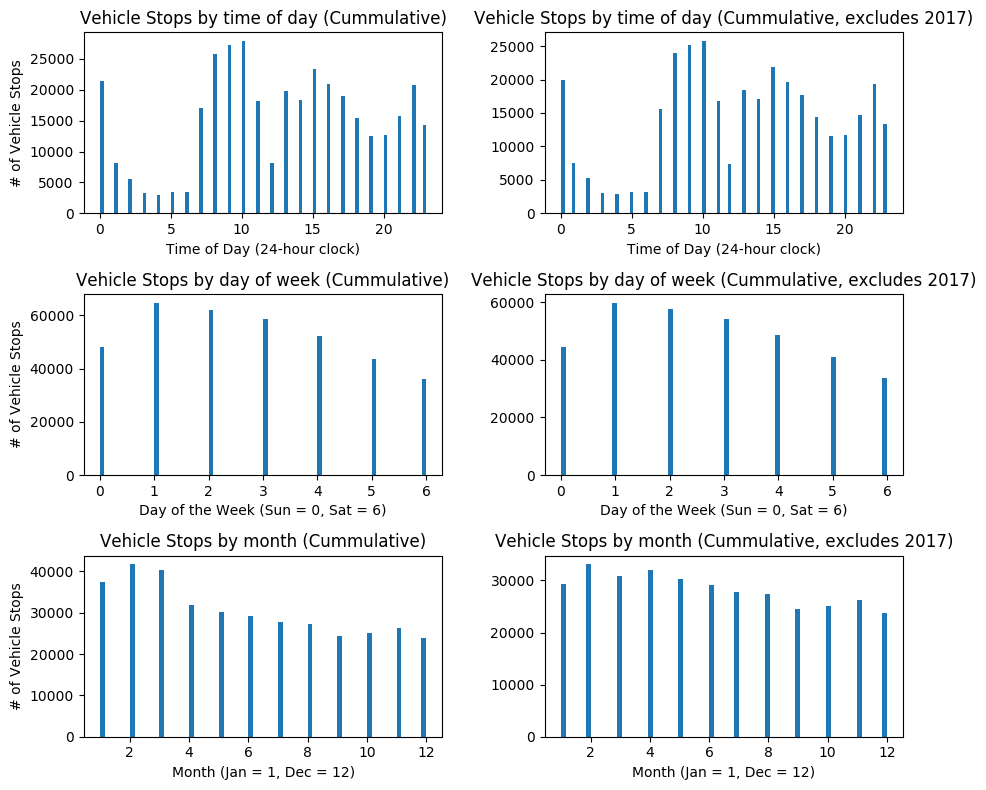

In [6]:
# Histograms of Vehicle Stops in terms of categorical time (on vs_all and vs_complete)

fig1 = plt.figure(figsize=(10, 8), dpi=100)

# Cummulative (all)
plt.subplot(3, 2, 1)
plt.xlabel('Time of Day (24-hour clock)')
plt.ylabel('# of Vehicle Stops')
plt.title("Vehicle Stops by time of day (Cummulative)")
plt.hist(vs_all['timestamp'].dt.hour, bins='auto')

plt.subplot(3, 2, 3)
plt.xlabel('Day of the Week (Sun = 0, Sat = 6)')
plt.ylabel('# of Vehicle Stops')
plt.title("Vehicle Stops by day of week (Cummulative)")
plt.hist(vs_all['weekday'], bins='auto')

plt.subplot(3, 2, 5)
plt.xlabel('Month (Jan = 1, Dec = 12)')
plt.ylabel('# of Vehicle Stops')
plt.title("Vehicle Stops by month (Cummulative)")
plt.hist(vs_all['month'], bins='auto')

# Cummunlative (excluding 2017)
plt.subplot(3, 2, 2)
plt.xlabel('Time of Day (24-hour clock)')
plt.title("Vehicle Stops by time of day (Cummulative, excludes 2017)")
plt.hist(vs_complete['timestamp'].dt.hour, bins='auto')

plt.subplot(3, 2, 4)
plt.xlabel('Day of the Week (Sun = 0, Sat = 6)')
plt.title("Vehicle Stops by day of week (Cummulative, excludes 2017)")
plt.hist(vs_complete['weekday'], bins='auto')

plt.subplot(3, 2, 6)
plt.xlabel('Month (Jan = 1, Dec = 12)')
plt.title("Vehicle Stops by month (Cummulative, excludes 2017)")
plt.hist(vs_complete['month'], bins='auto')

plt.tight_layout()
plt.show()

We can see that the plots for time of day and day of week are nearly identical between each of the two cummulative plots. As expected, the plot by month for the cummulative dataset excluding 2017 also has less of a gap between the number of stops during the first three months and the number of stops during the rest of the year. However, we can see that there is still a noticeable downward trend.

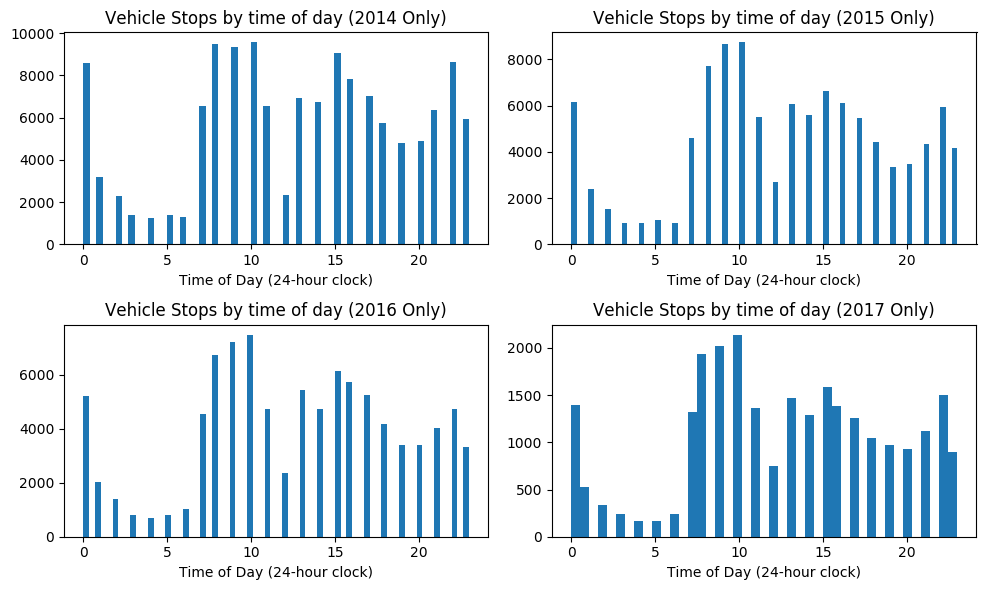

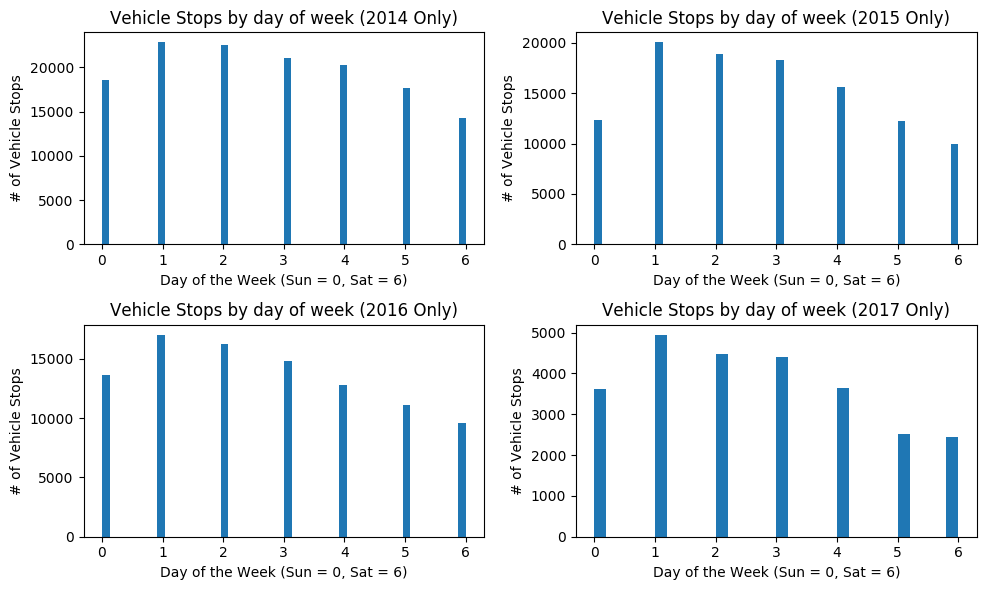

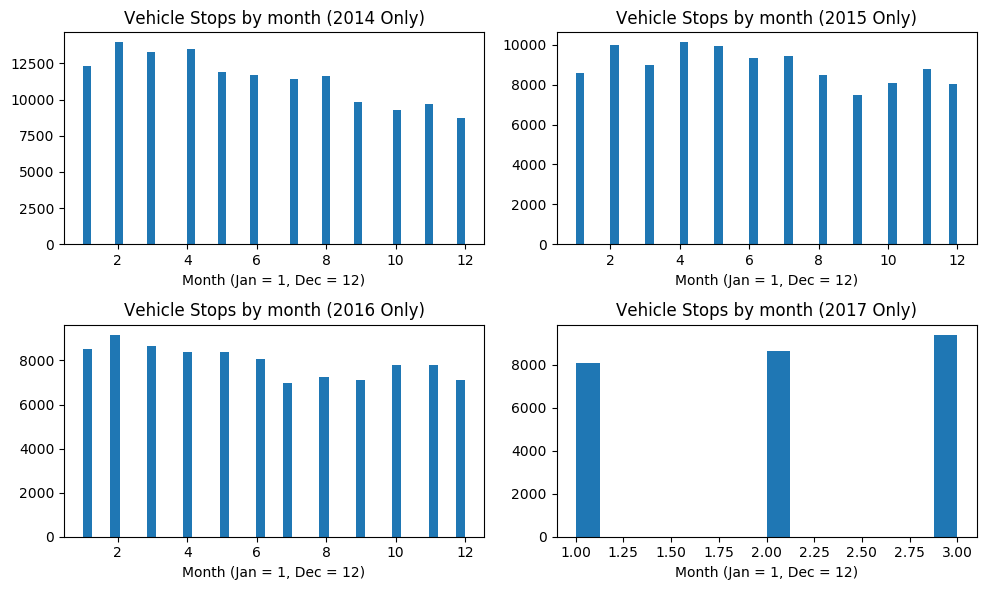

In [7]:
# Histograms of Vehicle Stops in terms of categorical time (for each year)

# Time of Day (by 2014, 2015, 2016, 2017)
fig2 = plt.figure(figsize=(10, 6), dpi=100)

plt.subplot(2, 2, 1)
plt.xlabel('Time of Day (24-hour clock)')
plt.title("Vehicle Stops by time of day (2014 Only)")
plt.hist(vs_14['timestamp'].dt.hour, bins='auto')

plt.subplot(2, 2, 2)
plt.xlabel('Time of Day (24-hour clock)')
plt.title("Vehicle Stops by time of day (2015 Only)")
plt.hist(vs_15['timestamp'].dt.hour, bins='auto')

plt.subplot(2, 2, 3)
plt.xlabel('Time of Day (24-hour clock)')
plt.title("Vehicle Stops by time of day (2016 Only)")
plt.hist(vs_16['timestamp'].dt.hour, bins='auto')

plt.subplot(2, 2, 4)
plt.xlabel('Time of Day (24-hour clock)')
plt.title("Vehicle Stops by time of day (2017 Only)")
plt.hist(vs_17['timestamp'].dt.hour, bins='auto')

plt.tight_layout()
plt.show()

# Day of Week (by 2014, 2015, 2016, 2017)
fig3 = plt.figure(figsize=(10, 6), dpi=100)

plt.subplot(2, 2, 1)
plt.xlabel('Day of the Week (Sun = 0, Sat = 6)')
plt.ylabel('# of Vehicle Stops')
plt.title("Vehicle Stops by day of week (2014 Only)")
plt.hist(vs_14['weekday'], bins='auto')

plt.subplot(2, 2, 2)
plt.xlabel('Day of the Week (Sun = 0, Sat = 6)')
plt.ylabel('# of Vehicle Stops')
plt.title("Vehicle Stops by day of week (2015 Only)")
plt.hist(vs_15['weekday'], bins='auto')

plt.subplot(2, 2, 3)
plt.xlabel('Day of the Week (Sun = 0, Sat = 6)')
plt.ylabel('# of Vehicle Stops')
plt.title("Vehicle Stops by day of week (2016 Only)")
plt.hist(vs_16['weekday'], bins='auto')

plt.subplot(2, 2, 4)
plt.xlabel('Day of the Week (Sun = 0, Sat = 6)')
plt.ylabel('# of Vehicle Stops')
plt.title("Vehicle Stops by day of week (2017 Only)")
plt.hist(vs_17['weekday'], bins='auto')

plt.tight_layout()
plt.show()

# Month (by 2014, 2015, 2016, 2017)
# These are a bit redundant, since we will see the plots combined together in the temporal monthly plot
fig4 = plt.figure(figsize=(10, 6), dpi=100)

plt.subplot(2, 2, 1)
plt.xlabel('Month (Jan = 1, Dec = 12)')
plt.title("Vehicle Stops by month (2014 Only)")
plt.hist(vs_14['month'], bins='auto')

plt.subplot(2, 2, 2)
plt.xlabel('Month (Jan = 1, Dec = 12)')
plt.title("Vehicle Stops by month (2015 Only)")
plt.hist(vs_15['month'], bins='auto')

plt.subplot(2, 2, 3)
plt.xlabel('Month (Jan = 1, Dec = 12)')
plt.title("Vehicle Stops by month (2016 Only)")
plt.hist(vs_16['month'], bins='auto')

plt.subplot(2, 2, 4)
plt.xlabel('Month (Jan = 1, Dec = 12)')
plt.title("Vehicle Stops by month (2017 Only)")
plt.hist(vs_17['month'], bins='auto')

plt.tight_layout()
plt.show()

From these plots, we can see that each year has the same general trends for hourly, weekly, and monthly vehicle stops. For each year, the number of vehicle stops peaks around rush hour in the morning (8-10AM). There are also slightly lower peaks around rush hour in the evening, but these vary slightly between each year. For 2014, the peak appears prominently at 3PM, but for subsequent years, the peak is distributed across 1-5PM. In all of the plots, we can see that there is a very noticeable dip around 12PM, which would correspond to typical lunch hours. We can also see there is more activity around 10PM and 12PM, with another dip in activity in between these two peak hours at 11PM. Expectedly, during the nighttime hours of 1-6PM the frequency of vehicle stops decreases dramatically.

We can also see that the trend for stops across the days of the week is nearly identical between each year. Each plot starts out with a peak number of stops on Monday. We then see a downward trend as the week goes by, until we hit Sunday, when the number of stops increases to a level comparable to those of Thursday and Friday.

As for the months, we can see that the number of stops generally peaks towards the beginning of the year (noticeably February or April) and then decreases as the year goes by. For the 2015 and 2016 plots, we can also see that there is a secondary peak around October and November

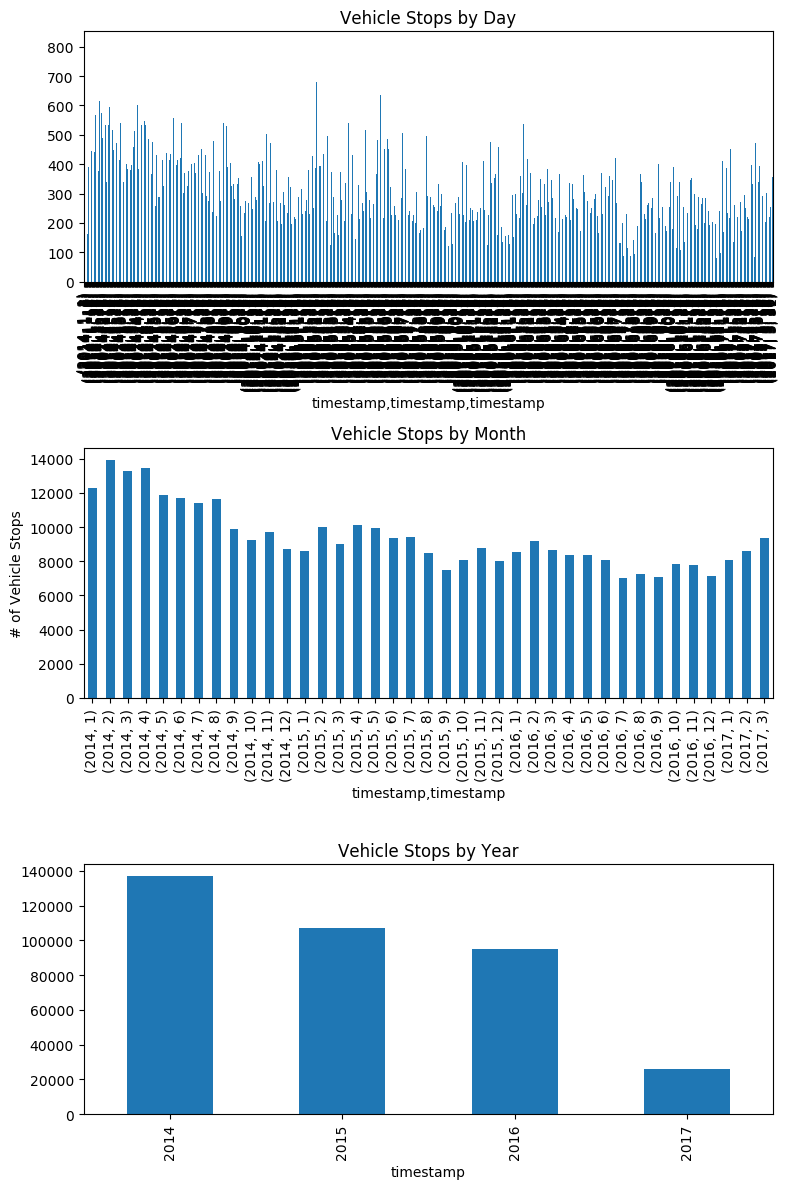

In [8]:
# Histograms of Vehicle Stops in terms of temporal time

year = vs_all["timestamp"].dt.year
month = vs_all["timestamp"].dt.month
day = vs_all["timestamp"].dt.day

fig5 = plt.figure(figsize=(8, 12), dpi=100)

plt.subplot(311)
plt.xlabel('Date (Year, Month, Day)')
plt.title("Vehicle Stops by Day")
vs_all["timestamp"].groupby([year, month, day]).count().plot(kind="bar")

plt.subplot(312)
plt.xlabel('Month (Year, Month)')
plt.ylabel('# of Vehicle Stops')
plt.title("Vehicle Stops by Month")
vs_all["timestamp"].groupby([year, month]).count().plot(kind="bar")

plt.subplot(313)
plt.xlabel('Year')
plt.title("Vehicle Stops by Year")
vs_all["timestamp"].groupby([year]).count().plot(kind="bar")

plt.tight_layout()
plt.show()

Though it is hard to see from the "Vehicle Stops by Day" graph, there are a few days that have an unusually high number of traffic stops. We'll have to replot it so that we can see these days more clearly. Additionally, in the next section we will tabulate the days with the most number of traffic stops using value_counts().

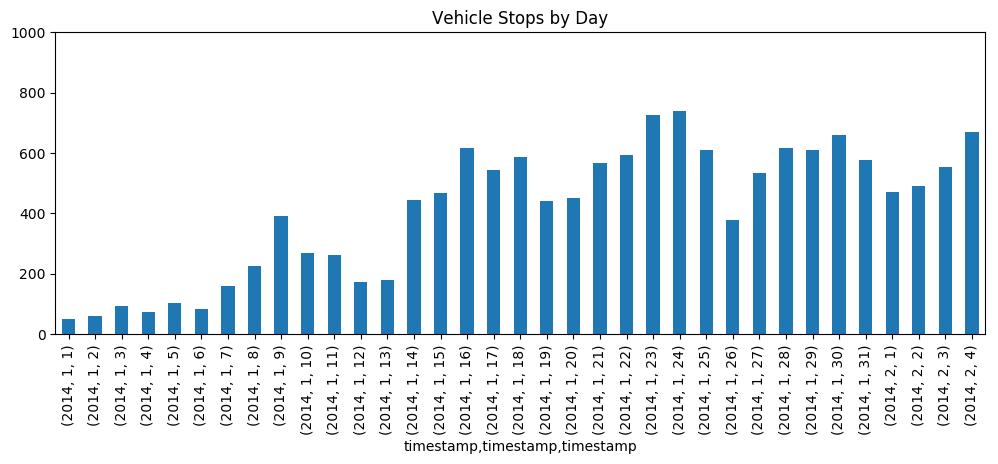

<function __main__.pltsin>

In [9]:
# The graph of the vehicle stops by day is a bit difficult to see when we plot it out all at once
# Let's make an interactive plot that lets us scroll through time to view a range of dates

import ipywidgets as widgets
from ipywidgets import interact

day_data = vs_all["timestamp"].groupby([year, month, day]).count()

def pltsin(f):
    fig6 = plt.figure(figsize=(12, 4), dpi=100)
    plt.xlabel('Date (Year, Month, Day)')
    plt.title("Vehicle Stops by Day")
    plt.gca().set_ylim([0, 1000])
    # Total number of days = 1186, so to make the graph nice and even, we set the range of points shown to be 36
    day_data[0+f:35+f].plot(kind="bar")
    plt.show()
    
interact(pltsin, f=widgets.IntSlider(min=0,max=1150,step=1,continuous_update=False,readout=False))

### Histograms for Other Parameters

Now let's go ahead and visualize some of the other parameters included in our data. We may be able to see some interesting patterns.

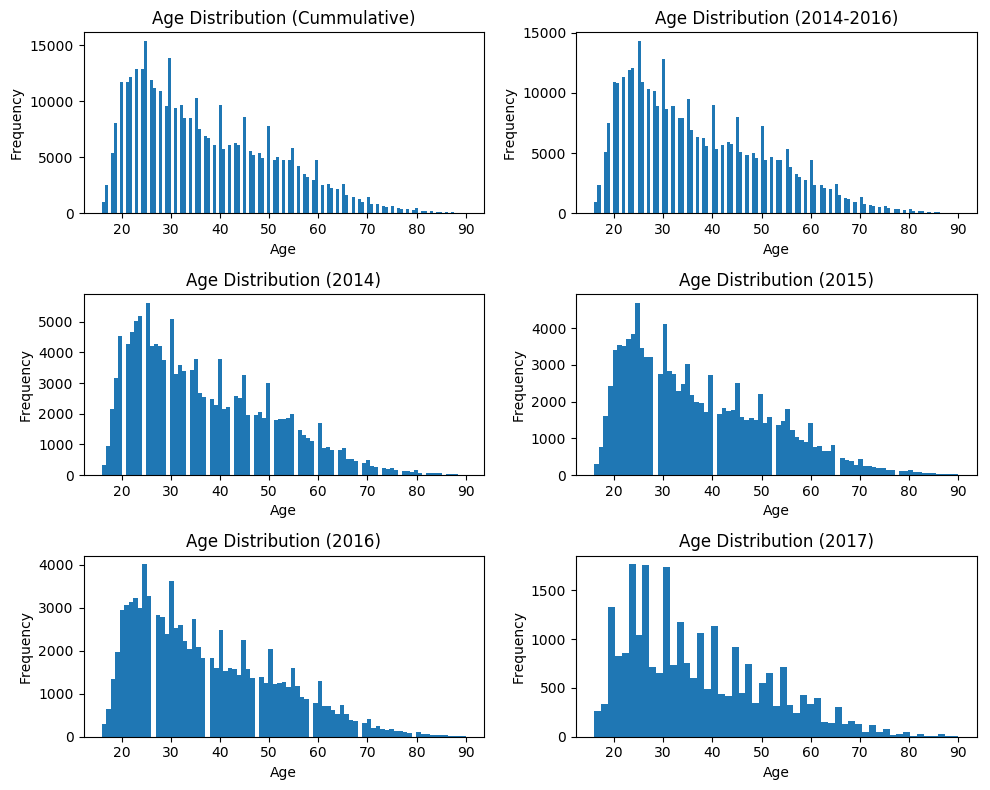

In [10]:
#Histograms of age from 2014 to 2017
fig_age = plt.figure(figsize=(10,8), dpi=100)

#Cummulative(2014-2017)
plt.subplot(321)
plt.hist(vs_all['subject_age'], bins='auto')
plt.axis('auto')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution (Cummulative)')

#Cummulative excluding 2017 (2014-2016)
plt.subplot(322)
plt.hist(vs_complete['subject_age'], bins='auto')
plt.axis('auto')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution (2014-2016)')

#For individual years (2014-2017)
plt.subplot(323)
plt.hist(vs_14['subject_age'], bins='auto')
plt.axis('auto')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution (2014)')

plt.subplot(324)
plt.hist(vs_15['subject_age'], bins='auto')
plt.axis('auto')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution (2015)')

plt.subplot(325)
plt.hist(vs_16['subject_age'],bins='auto')
plt.axis('auto')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution (2016)')

plt.subplot(326)
plt.hist(vs_17['subject_age'],bins='auto')
plt.axis('auto')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution (2017)')

plt.tight_layout()

There is a very clear trend in the age distribution across all of the years. The number of violations starts out at low levels, then peaks between ages 20 and 30, and then gradually declines until we see very few violations in the 80 to 90-year-old range.

Somewhat troubling is the frequency of stops for ages that are a multiple of 5, when compared to ages in the same range. A plot of age would typically be fairly smooth, but the spikes at these specific age intervals suggests that there may be some bias when logging the age data for each vehicle stop. 

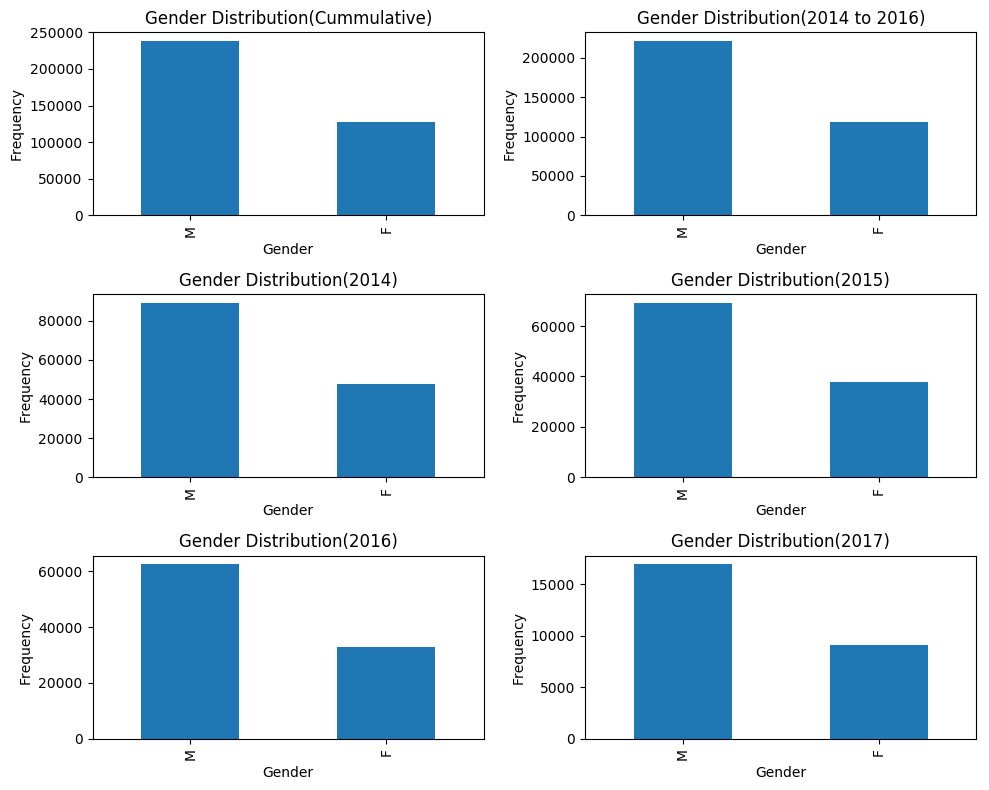

In [11]:
#Histograms of gender from 2014 to 2017
fig_gender = plt.figure(figsize=(10,8), dpi=100)

#Cummulative
plt.subplot(321)
all_gen = vs_all['subject_sex'].value_counts()
all_gen.plot('bar')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Gender Distribution(Cummulative)')

#Cummulative excluding 2017 (2014-2016)
plt.subplot(322)
excl_gen = vs_complete['subject_sex'].value_counts()
excl_gen.plot('bar')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Gender Distribution(2014 to 2016)')

#For individual years (2014 to 2017)
plt.subplot(323)
four_gen = vs_14['subject_sex'].value_counts()
four_gen.plot('bar')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Gender Distribution(2014)')

plt.subplot(324)
five_gen = vs_15['subject_sex'].value_counts()
five_gen.plot('bar')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Gender Distribution(2015)')

plt.subplot(325)
six_gen = vs_16['subject_sex'].value_counts()
six_gen.plot('bar')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Gender Distribution(2016)')

plt.subplot(326)
seven_gen = vs_17['subject_sex'].value_counts()
seven_gen.plot('bar')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Gender Distribution(2017)')

plt.tight_layout()

From these plots, we can see there are clearly far more vehicle stops for males than for females. 

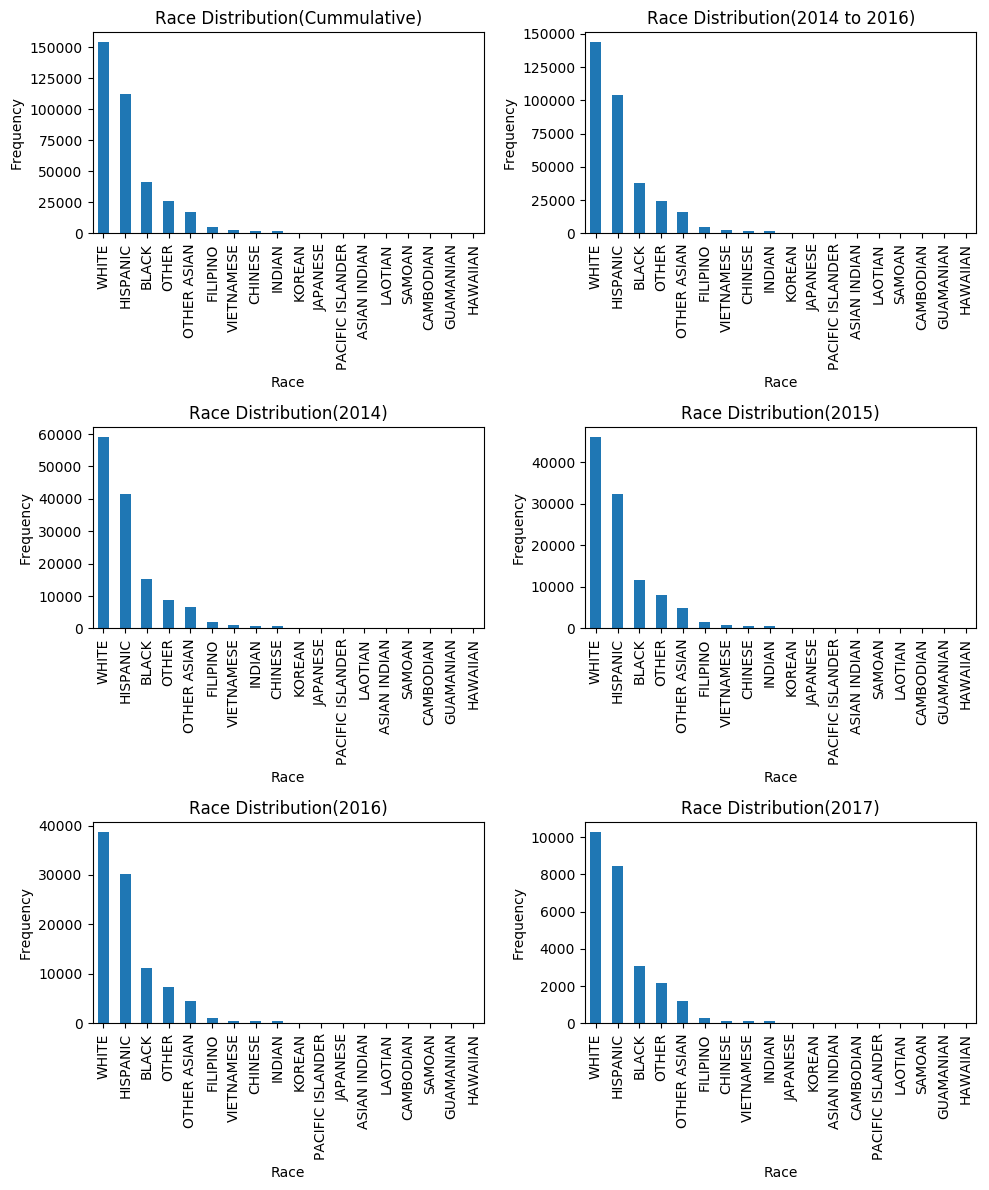

In [12]:
#Histograms of race from 2014 to 2017

fig_race = plt.figure(figsize=(10,12), dpi=100)

#Cummulative
plt.subplot(321)
all_race = vs_all['subject_race'].value_counts()
all_race.plot('bar')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.title('Race Distribution(Cummulative)')

#Cummulative excluding 2017 (2014-2016)
plt.subplot(322)
excl_race = vs_complete['subject_race'].value_counts()
excl_race.plot('bar')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.title('Race Distribution(2014 to 2016)')

#For individual years (2014 to 2017)
plt.subplot(323)
four_race = vs_14['subject_race'].value_counts()
four_race.plot('bar')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.title('Race Distribution(2014)')

plt.subplot(324)
five_race = vs_15['subject_race'].value_counts()
five_race.plot('bar')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.title('Race Distribution(2015)')

plt.subplot(325)
six_race = vs_16['subject_race'].value_counts()
six_race.plot('bar')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.title('Race Distribution(2016)')

plt.subplot(326)
seven_race = vs_17['subject_race'].value_counts()
seven_race.plot('bar')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.title('Race Distribution(2017)')

plt.tight_layout()

The distribution for the top six most frequently stopped races are fairly consistent. White drivers are consistently stopped the most often, followed by Hispanic, Black, Other, Other Asian, and Filipino drivers. For the other races, the distribution changes slightly between year to year. For instance, Indian drivers had more stops than Chinese drivers in 2014, but in 2015 Indian drivers had less stops than Chinese drivers.

When we take a look at this distribution compared to the racial demographic data in San Diego county (Source: https://datausa.io/profile/geo/san-diego-county-ca/#ethnicity), we can actually see that there does in fact seem to be some racial bias against Black drivers. They consist of nearly half the population of Asian drivers, but in our vehicle stop histogram, they are stopped nearly twice as much. One factor to take into consideration is that the DataUSA graph shows Asians in one collective catagory while the San Diego county data separates them into more specific catagories. However, even if combine the number of stops for all the Asian races, there would still be less stops for Asians combined than for Black drivers.

(0.625, 19.125)

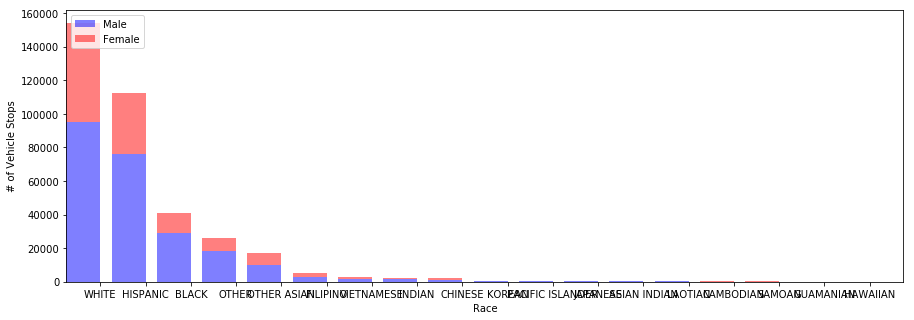

In [13]:
vs_m = vs_all[vs_all['subject_sex'] == 'M']
vs_m = vs_m['subject_race'].value_counts()
vs_f = vs_all[vs_all['subject_sex'] == 'F']
vs_f = vs_f['subject_race'].value_counts()
vs_race = pd.DataFrame(vs_m)
vs_race['f'] = vs_f
vs_race.reset_index(level=0, inplace=True)
vs_race.columns = ['race', 'm', 'f']

f, ax1 = plt.subplots(1, figsize=(15,5))
bar_width = 0.75
bar_l = [i+1 for i in range(len(vs_m))]
tick_pos = [i+(bar_width/2) for i in bar_l]

ax1.bar(bar_l, vs_race['m'], width=bar_width, label='Male', alpha=0.5, color='blue')
ax1.bar(bar_l, vs_race['f'], width=bar_width, bottom=vs_race['m'], label='Female',alpha=0.5, color='red')

plt.xticks(tick_pos, vs_race['race'])
ax1.set_ylabel("# of Vehicle Stops")
ax1.set_xlabel("Race")
plt.legend(loc='upper left')
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

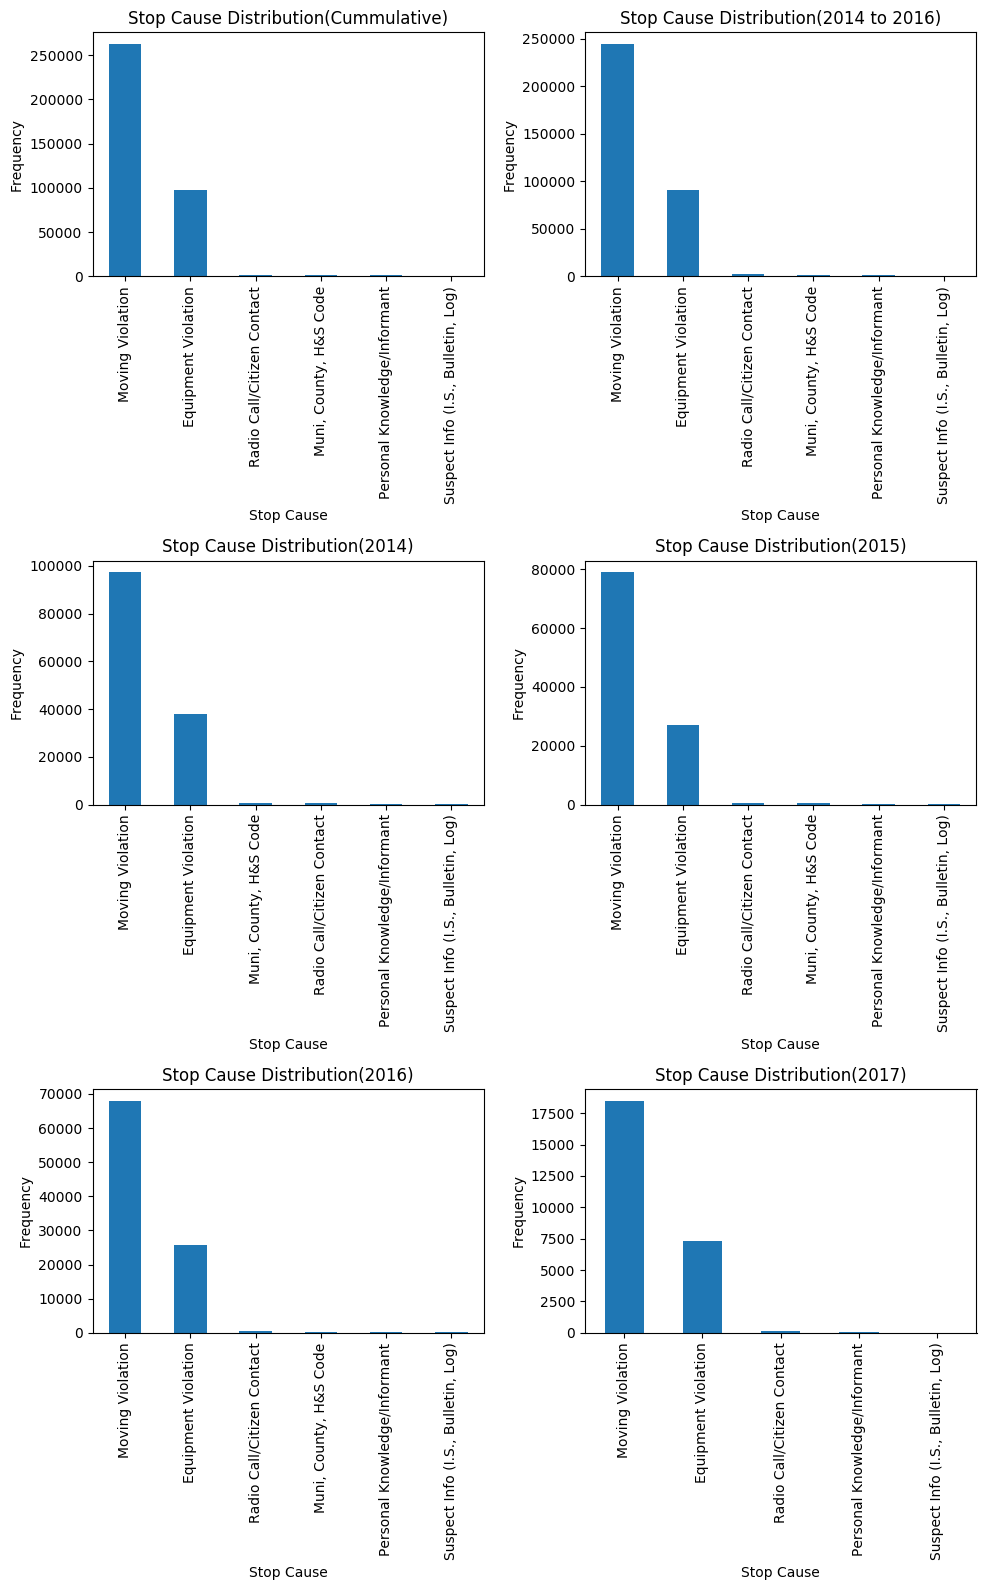

In [14]:
#Histograms of stop causes from 2014 to 2017

fig_cause = plt.figure(figsize=(10,16), dpi=100)

#Cummulative
plt.subplot(321)
all_cause = vs_all['stop_cause'].value_counts()
all_cause.plot('bar')
plt.xlabel('Stop Cause')
plt.ylabel('Frequency')
plt.title('Stop Cause Distribution(Cummulative)')

#Cummulative excluding 2017 (2014-2016)
plt.subplot(322)
excl_cause = vs_complete['stop_cause'].value_counts()
excl_cause.plot('bar')
plt.xlabel('Stop Cause')
plt.ylabel('Frequency')
plt.title('Stop Cause Distribution(2014 to 2016)')

#For individual years (2014 to 2017)
plt.subplot(323)
four_cause = vs_14['stop_cause'].value_counts()
four_cause.plot('bar')
plt.xlabel('Stop Cause')
plt.ylabel('Frequency')
plt.title('Stop Cause Distribution(2014)')

plt.subplot(324)
five_cause = vs_15['stop_cause'].value_counts()
five_cause.plot('bar')
plt.xlabel('Stop Cause')
plt.ylabel('Frequency')
plt.title('Stop Cause Distribution(2015)')

plt.subplot(325)
six_cause = vs_16['stop_cause'].value_counts()
six_cause.plot('bar')
plt.xlabel('Stop Cause')
plt.ylabel('Frequency')
plt.title('Stop Cause Distribution(2016)')

plt.subplot(326)
seven_cause = vs_17['stop_cause'].value_counts()
seven_cause.plot('bar')
plt.xlabel('Stop Cause')
plt.ylabel('Frequency')
plt.title('Stop Cause Distribution(2017)')

plt.tight_layout()

Across the board, there are far more stops resulting from Moving Violations and Equipment Violations than all other causes. Additionally, there are nearly three times as many Moving Violations than there are Equipment Violations.

(0.625, 7.125)

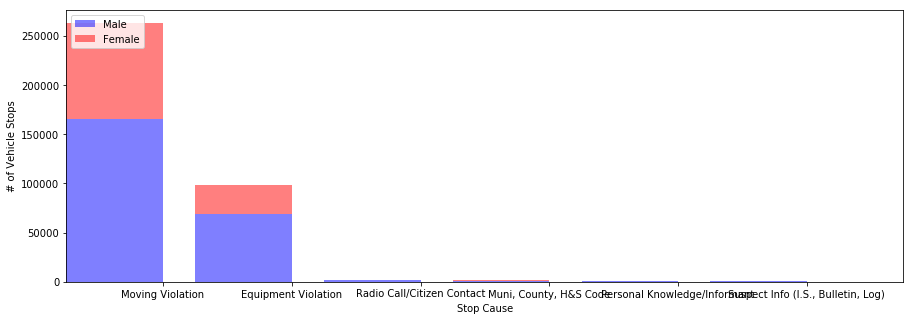

In [15]:
vs_m = vs_all[vs_all['subject_sex'] == 'M']
vs_m = vs_m['stop_cause'].value_counts()
vs_f = vs_all[vs_all['subject_sex'] == 'F']
vs_f = vs_f['stop_cause'].value_counts()
vs_sc = pd.DataFrame(vs_m)
vs_sc['f'] = vs_f
vs_sc.reset_index(level=0, inplace=True)
vs_sc.columns = ['stop_cause', 'm', 'f']

f2, ax2 = plt.subplots(1, figsize=(15,5))
bar_width = 0.75
bar_2 = [i+1 for i in range(len(vs_m))]
tick_pos = [i+(bar_width/2) for i in bar_2]

ax2.bar(bar_2, vs_sc['m'], width=bar_width, label='Male', alpha=0.5, color='blue')
ax2.bar(bar_2, vs_sc['f'], width=bar_width, bottom=vs_sc['m'], label='Female', alpha=0.5, color='red')

plt.xticks(tick_pos, vs_sc['stop_cause'])
ax2.set_ylabel("# of Vehicle Stops")
ax2.set_xlabel("Stop Cause")
plt.legend(loc='upper left')
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

<div class="alert alert-info">
First Install these packages before running the Interactive Heatmap: <br>
- pip install pyshp<br>
- pip install bokeh
</div>

### Heatmap of Traffic Stops in San Diego
To create the heatmap, we need the shapefiles of each police beat in San Diego and the data from our police traffic stop datasets.
- First, we take the police beat data from 'pd_beat_neighborhoods_datasd.csv' to get all the beats and their service areas.
- Then, we take the neighborhood data from the Zillow dataset and match the neighborhoods from Zillow with the police beats neighborhoods.
- We try to match as many neighborhoods as we can so we can get an accurate representation of San Diego.
- Next, we take the shapefiles of the neighborhoods matched from Zillow and create a mapof San Diego.
- Now, we take our traffic stops data for each service area, then match the neighborhoods with their service area, and create the heatmap.
- Finally, we add interactive controls to the heatmap so we can select certain data conditions and view the effects they have on the heatmap.

In [16]:
# Sort police beats into service areas.
police_beats = pd.read_csv('pd_beat_neighborhoods_datasd.csv')
# Remove 'Oak Park' because data for service area 450 doesn't exist
police_beats = police_beats.loc[(police_beats['Neighborhood'] != 'Oak Park')]
police_beats['Beat'] = police_beats['Beat'].astype(str)
beats_from_data = police_beats['Neighborhood'].tolist()

# working with shapefiles
# neighborhood shapefile data from Zillow:
# https://www.zillow.com/howto/api/neighborhood-boundaries.htm
#
# shapefile package: pyshp
# https://pypi.python.org/pypi/pyshp
#   Approach taken from Lecture Materials: https://github.com/COGS108/LectureMaterials/blob/master/Geospatial/GeospatialAnalytics.ipynb

import shapefile

# read the in the shapefile and list the methods associated with the object
sf = shapefile.Reader("ZillowNeighborhoods-CA.shp")

# read in the dbf (metadata) file and list all the methods associated with it
sfdbf = shapefile.Reader("ZillowNeighborhoods-CA.dbf")

# find indices of all San Diego neighborhoods
metadata = sfdbf.shapeRecords()

sd_index = []
beats_from_zillow = []
final_beats_zillow = []

# Get the names of all the neighborhoods in San Diego County from Zillow dataset
for i in range(len(metadata)):
    if metadata[i].record[1] == 'San Diego':
        beats_from_zillow.append(metadata[i].record[3])
        if metadata[i].record[3] in beats_from_data:
            final_beats_zillow.append(metadata[i].record[3])

# need to keep track of name in data to properly create service areas
# final_beats_data contains all neighborhoods from the Zillow dataset that match with the police beats dataset
final_beats_data = final_beats_zillow.copy()

# Get the remaining neighborhoods with names that don't match up because of spelling differences
for data in (set(beats_from_data) - set(beats_from_zillow)):
    for zillow in (set(beats_from_zillow) - set(beats_from_data)):
        # Some beats have the same starting substrings but are not the same city so we need to check the ending substring as well.
        if data[0:4] == zillow[0:4] and data[-3:] == zillow[-3:]:
            # Keep track of all neighborhoods from Zillow dataset and Police Beats dataset
            final_beats_zillow.append(zillow)
            final_beats_data.append(data)

# Manual addition, can't find a good way to programmically add these without adding unnecessary neighborhoods 
final_beats_zillow.append('Cortez Hill')
final_beats_zillow.append('Gaslamp Quarter')
final_beats_zillow.append('Jomacha-Lomita')
final_beats_zillow.append('Rancho Encantado')
# Add in names that correspond to the data
final_beats_data.append('Cortez')
final_beats_data.append('Gaslamp')
final_beats_data.append('Jamacha/Lomita')
final_beats_data.append('Rancho Encantada')

#  'Broadway Heights', "O'Farrell", 'Petco Park', 'Qualcomm', and 'Rolando Park' are not in zillow so we will not
#  be using these neighborhoods.

# Need indices in order they were added so final beats to line up correctly with their indices in the Zillow metadata
for beat in final_beats_zillow:
    for i in range(len(metadata)):
        if metadata[i].record[1] == 'San Diego' and metadata[i].record[3] == beat:
            sd_index.append(i)
            continue
            
# Get shapes of each beat
shapes = sf.shapes()
sd_shapes = []
for i in range(len(sd_index)):
    sd_shapes.append(shapes[sd_index[i]].points)

# Get the latitude and longitude of each neighborhood, in order of indices 
beats = []
beats_lons = []
beats_lats = []
for i in range(len(sd_shapes)):
    beats.append(sd_shapes[i])
    beats_lons.append([xy[0] for xy in beats[i]])
    beats_lats.append([xy[1] for xy in beats[i]])
    
# Group beats(value) by service area(key) indices(value) by service area(key)
service_areas = vs_complete['service_area'].value_counts().index.tolist()
beats_by_service_area = {}
# indices(value) by service area(key)
index_by_service_area = {}

# Sort beats by service area
for area in sorted(service_areas):
    temp = police_beats.loc[(police_beats['Beat'].str[0:2] == area[0:2])]
    beats_by_service_area[area] = temp['Neighborhood'].tolist()
    indices = []
    for beat in temp['Neighborhood'].tolist():
        if beat in final_beats_data:
            indices.append(final_beats_data.index(beat))
    index_by_service_area[area] = indices.copy()

# Get list of all beats that belong in a service area from the dataset
# Some beats don't fall under a service area from the dataset
beats_in_dict = []
for service_area in beats_by_service_area.values():
    for beat in service_area:
        beats_in_dict.append(beat)

# array of service area numbers corresponding to index number
which_service_area_is_each_beat = [''] * len(final_beats_zillow)
for key in index_by_service_area:
    for index in index_by_service_area[key]:
        which_service_area_is_each_beat[index] = key

# Use to get the initial data to use in the heatmap
range_regions_all = vs_all['service_area'].value_counts()
list_regions = range_regions_all.index.tolist() # Can't use a key to dereference range_regions_all 

# Get traffic stop counts for each service area
ts_per_sa = []
for area in which_service_area_is_each_beat:
    try:
        ts_per_sa.append(range_regions_all[list_regions.index(area)])
    except:
        ts_per_sa.append(0)

In [17]:
# Imports need to create heatmap
#   Approach taken from: http://bokeh.pydata.org/en/latest/docs/gallery/texas.html 
#     and https://github.com/bokeh/bokeh/blob/0.12.5/examples/howto/notebook_comms/Jupyter%20Interactors.ipynb
#     and http://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
#     and https://stackoverflow.com/questions/40533394/updating-bokeh-plot-with-a-bokeh-widget-in-jupyter-notebook
import bokeh
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, CheckboxButtonGroup, RadioButtonGroup
from bokeh.palettes import YlOrRd9 as palette
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import layout, widgetbox, column, row
from ipywidgets import interactive, interact

palette.reverse()
color_mapper = LinearColorMapper(palette=palette)
output_notebook()

Loading BokehJS ...

In [18]:
def select_years(start_year, end_year, hour, day, month):
    selected = vs_all[
            (vs_all['timestamp'].dt.year >= start_year) & 
            (vs_all['timestamp'].dt.year <= end_year) 
    ]
    # If hour == 24 then display all hours
    if hour != 24:
        selected = selected[(selected['hour'] == hour)]
    # If day == 7 then display all days of the week
    if day != 7:
        selected = selected[(selected['weekday'] == day)]
    # If month == 13 then display all months
    if month != 13:
        selected = selected[(selected['month'] == month)]

    return selected

def update(StartYear=2014, EndYear=2017, Hour=24, Day=7, Month=13):
    # Get datafram of selected years
    years_selected = select_years(StartYear, EndYear, Hour, Day, Month)
    data = source.data
    # Now to separate traffic stops by year and time of day
    range_regions = years_selected['service_area'].value_counts()
    list_regions = range_regions.index.tolist() # Can't use a key to dereference range_regions_all 

    # Get traffic stop counts for each service area
    ts_per_sa = []
    for area in which_service_area_is_each_beat:
        try:
            ts = range_regions[list_regions.index(area)]
        except ValueError:
            ts = 0
        ts_per_sa.append(ts)
    data['traffic_stops'] = ts_per_sa
    push_notebook()

In [19]:
source = ColumnDataSource(data=dict(
    x=beats_lons,
    y=beats_lats,
    name=final_beats_zillow,
    service_number=which_service_area_is_each_beat,
    traffic_stops=ts_per_sa,
))

TOOLS = "hover"

p = figure(
    title="Heat Map of Traffic Stops of San Diego County", tools=TOOLS,
    toolbar_location=None, x_axis_location=None, y_axis_location=None,
    plot_width=600, plot_height=900
)

p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_color={'field': 'traffic_stops', 'transform': color_mapper},
          fill_alpha=0.9, line_color="white", line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("Service Area", "@service_number"),
    ("Traffic Stops", "@traffic_stops"),
    ("(Long, Lat)", "($x, $y)"),
]

callback = CustomJS(args=dict(source=source), code="""
    var data = source.data;
    var sy = start_year.value;
    var ey = end_year.value;
    var hour = time_of_day.value;
    var day = day_of_week.value;
    var mon = month.value;
    if (IPython.notebook.kernel !== undefined) {
        var kernel = IPython.notebook.kernel;
        cmd = "update(" + sy + ", " + ey + ", " + hour + ", " + day + ", " + mon + ")";
        kernel.execute(cmd, {}, {});
    }
""")

start_year_slider = Slider(start=2014, end=2017, value=2014, step=1, title="Start Year", callback=callback)
callback.args["start_year"] = start_year_slider

end_year_slider = Slider(start=2014, end=2017, value=2017, step=1, title="End Year", callback=callback)
callback.args["end_year"] = end_year_slider

time_of_day_slider = Slider(start=0, end=24, value=24, step=1, title="Time of Day (24 = All Hours)", callback=callback)
callback.args["time_of_day"] = time_of_day_slider

day_of_week_slider = Slider(start=0, end=7, value=7, step=1, title="Day Of Week (7 = All Days)", callback=callback)
callback.args["day_of_week"] = day_of_week_slider

month_slider = Slider(start=1, end=13, value=13, step=1, title="Month (13 = All Months)", callback=callback)
callback.args["month"] = month_slider

layout = row(
    p,
    widgetbox(start_year_slider, end_year_slider, time_of_day_slider, day_of_week_slider, month_slider),
)

In [20]:
show(layout, notebook_handle=True)

#### Bokeh visuals don't show up on github, here is a sample image:
This is a snapshot of the heatmap representing the all the traffic stops from January 1,2014 to March 31, 2017
<img src="http://i.imgur.com/PLmD35W.png" alt="heatmap" class="inline"/>

### Data Visualization Conclusions:
Although each subsequent year has considerable less vehicle stops than the year prior, the patterns and trend remain consistent throughout every variable. Both the cummulative and noncummulative distributions for region, time, age, gender, race, and stop cause are all largely similar. This suggests that there are no outlier years that may act as potential confounds that could  significantly affect the data of the vs_all dataset. 

# Part 5: Data Analysis Results

We will check for the:
- range of violations in different regions
- range of violations at different times (day - overall, time of day, day of week, month)
- regions with the most/least vehicle violations
- times with the most/least vehicle violations (day - overall, time of day, day of week, month)

Also, we will be using OLS to see if there are any correlations between the number of stops and certain times and locations.

### Maximum, Minimum, and Range of Values

In [21]:
ns_day = vs_complete['timestamp'].dt.date.value_counts()

print('Maximum Number of Stops in a Day: ', ns_day.values[0], ' on ' , ns_day.index[0] , '\n')
print('Minimum Number of Stops in a Day: ', ns_day.values[ns_day.size - 1], ' on ', ns_day.index[ns_day.size - 1], '\n')
print('Range of Stops: ', ns_day.values[0] - ns_day.values[ns_day.size - 1], '\n')
print('Number of Stops for Each Day:\n', ns_day, '\n', sep='')

Maximum Number of Stops in a Day:  812  on  2014-02-05 

Minimum Number of Stops in a Day:  40  on  2016-12-25 

Range of Stops:  772 

Number of Stops for Each Day:
2014-02-05    812
2014-01-24    738
2014-01-23    725
2015-02-05    679
2014-02-04    668
2014-01-30    661
2015-04-21    650
2014-03-06    647
2015-05-26    635
2015-04-14    627
2015-02-06    627
2015-02-04    625
2014-03-04    621
2014-01-16    618
2014-01-28    617
2014-01-29    611
2014-01-25    610
2014-04-03    603
2014-02-13    597
2014-01-22    594
2014-02-14    594
2014-03-11    588
2014-02-25    588
2014-01-18    588
2014-05-20    583
2014-03-21    581
2015-05-27    577
2014-08-13    577
2015-03-11    576
2014-01-31    576
             ... 
2015-10-04    124
2016-07-08    124
2015-05-17    123
2016-10-15    122
2015-12-24    121
2016-09-25    121
2015-09-20    121
2015-12-06    120
2016-07-31    118
2016-07-24    116
2016-10-01    116
2016-10-16    114
2016-10-23    107
2015-10-11    106
2016-01-31    105
2014-0

(array([   3.,   10.,   25.,   33.,   91.,   91.,  107.,  125.,  124.,
          94.,   79.,   71.,   59.,   46.,   46.,   23.,   29.,   10.,
          13.,    8.,    4.,    2.,    0.,    2.,    0.,    1.]),
 array([  40.        ,   69.69230769,   99.38461538,  129.07692308,
         158.76923077,  188.46153846,  218.15384615,  247.84615385,
         277.53846154,  307.23076923,  336.92307692,  366.61538462,
         396.30769231,  426.        ,  455.69230769,  485.38461538,
         515.07692308,  544.76923077,  574.46153846,  604.15384615,
         633.84615385,  663.53846154,  693.23076923,  722.92307692,
         752.61538462,  782.30769231,  812.        ]),
 <a list of 26 Patch objects>)

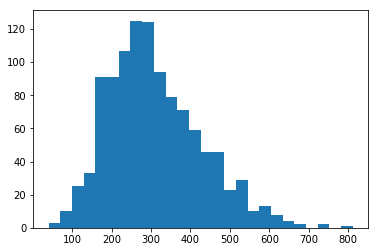

In [22]:
plt.hist(ns_day, bins='auto')

In [23]:
ns_regions = vs_complete['service_area'].value_counts()
print('Maximum Number of Stops in a Region: ', ns_regions[0], ' in region ', ns_regions.index[0], '\n')
print('Minimum Number of Stops in a Region: ', ns_regions[ns_regions.size - 1], ' in region ', ns_regions.index[ns_regions.size - 1], '\n')
print('Range of Stops Among All Regions: ', ns_regions[0] - ns_regions[ns_regions.size - 1], '\n')
print('Number of Stops in Each Region:\n', ns_regions, '\n', sep='')

Maximum Number of Stops in a Region:  27956  in region  310 

Minimum Number of Stops in a Region:  559  in region  530 

Range of Stops Among All Regions:  27397 

Number of Stops in Each Region:
310    27956
120    27862
520    27275
710    24968
240    24170
930    22723
110    21668
620    19486
230    18752
610    16970
720    16183
320    14694
430    13801
510    13570
810    12683
830    12666
440    12249
820    11449
530      559
Name: service_area, dtype: int64



In [24]:
ns_time_of_day  = vs_complete['timestamp'].dt.hour.value_counts()
print('Maximum Number of Stops During the Day: ', ns_time_of_day[0], ' at ' , ns_time_of_day.index[0] , '\n')
print('Minimum Number of Stops During the Day: ', ns_time_of_day[ns_time_of_day.size - 1], ' at ', ns_time_of_day.index[ns_time_of_day.size - 1], '\n')
print('Range of Stops During the Day: ', ns_time_of_day[0] - ns_time_of_day[ns_time_of_day.size - 1], '\n')
print('Number of Stops at Each Time of Day:\n', ns_time_of_day, '\n', sep='')

Maximum Number of Stops During the Day:  19981  at  10 

Minimum Number of Stops During the Day:  13429  at  4 

Range of Stops During the Day:  6552 

Number of Stops at Each Time of Day:
10    25764
9     25223
8     23897
15    21807
0     19981
16    19633
22    19290
13    18409
17    17743
14    17038
11    16757
7     15656
21    14716
18    14332
23    13429
20    11714
19    11586
1      7599
12     7407
2      5247
5      3253
6      3243
3      3090
4      2870
Name: timestamp, dtype: int64



In [25]:
ns_day_of_week = vs_complete['weekday'].value_counts()
print('Maximum Number of Stops During the Week: ', ns_day_of_week[0], ' on ' , ns_day_of_week.index[0] , '\n')
print('Minimum Number of Stops During the Week: ', ns_day_of_week[ns_day_of_week.size - 1], ' on ', ns_day_of_week.index[ns_day_of_week.size - 1], '\n')
print('Range of Stops During the Week: ', ns_day_of_week[0] - ns_day_of_week[ns_day_of_week.size - 1], '\n')
print('Number of Stops During Each Day of the Week:\n', ns_day_of_week, '\n', sep='')

Maximum Number of Stops During the Week:  44541  on  1 

Minimum Number of Stops During the Week:  33758  on  6 

Range of Stops During the Week:  10783 

Number of Stops During Each Day of the Week:
1    59892
2    57770
3    54165
4    48593
0    44541
5    40965
6    33758
Name: weekday, dtype: int64



In [26]:
ns_month = vs_complete['month'].value_counts()

print('Maximum Number of Stops During the Year: ', ns_month.values[0], ' in ' , ns_month.index[0] , '\n')
print('Minimum Number of Stops During the Year: ', ns_month.values[ns_month.size - 1], ' in ', ns_month.index[ns_month.size - 1], '\n')
print('Range of Stops During the Year: ', ns_month.values[0] - ns_month.values[ns_month.size - 1], '\n')
print('Number of Stops During Each Month:\n', ns_month, '\n', sep='')

Maximum Number of Stops During the Year:  33099  in  2 

Minimum Number of Stops During the Year:  23832  in  12 

Range of Stops During the Year:  9267 

Number of Stops During Each Month:
2     33099
4     31975
3     30925
5     30226
1     29399
6     29086
7     27851
8     27372
11    26302
10    25145
9     24472
12    23832
Name: month, dtype: int64



In [27]:
ns_stop_causes = vs_complete['stop_cause'].value_counts()
print('Maximum Number of Stops: ', ns_stop_causes[0], ' for ' , ns_stop_causes.index[0] , '\n')
print('Minimum Number of Stops: ', ns_stop_causes[ns_stop_causes.size - 1], ' for ', ns_stop_causes.index[ns_stop_causes.size - 1], '\n')
print('Range of Stops Among Stop Causes: ', ns_stop_causes.values[0] - ns_month.values[ns_stop_causes.size - 1], '\n')
print('Number of Stops for Each Stop Cause:\n', ns_stop_causes, '\n', sep='')

Maximum Number of Stops:  244351  for  Moving Violation 

Minimum Number of Stops:  533  for  Suspect Info (I.S., Bulletin, Log) 

Range of Stops Among Stop Causes:  215265 

Number of Stops for Each Stop Cause:
Moving Violation                      244351
Equipment Violation                    90735
Radio Call/Citizen Contact              1786
Muni, County, H&S Code                  1433
Personal Knowledge/Informant             846
Suspect Info (I.S., Bulletin, Log)       533
Name: stop_cause, dtype: int64



### OLS Analysis
Now let's see if we can predict the number of stops based on the time and the region

In [28]:
df1 = vs_all.groupby(["month", "service_area"]).size().reset_index(name="num_stops")

outcome_1, predictors_1 = patsy.dmatrices('num_stops ~ month + service_area', df1)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:              num_stops   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     92.20
Date:                Tue, 13 Jun 2017   Prob (F-statistic):           3.26e-90
Time:                        18:41:33   Log-Likelihood:                -1564.8
No. Observations:                 228   AIC:                             3170.
Df Residuals:                     208   BIC:                             3238.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            2499.0634    

Most of the p-values are <0.05 so it seems that the number of vehicle stops is significantly dependent on month in a majority of the service areas. In fact, only area 930 falls out of this trend. This data shows that, interestingly, stops in every area follow a very specific pattern throughout the year.    

In [29]:
df2 = vs_all.groupby(["weekday", "service_area"]).size().reset_index(name="num_stops")

outcome_2, predictors_2 = patsy.dmatrices('num_stops ~ weekday + service_area', df2)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()

print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:              num_stops   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     22.83
Date:                Tue, 13 Jun 2017   Prob (F-statistic):           3.84e-30
Time:                        18:41:33   Log-Likelihood:                -1030.4
No. Observations:                 133   AIC:                             2101.
Df Residuals:                     113   BIC:                             2159.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            3877.6805    

Similar to month, the day of the week in service areas is also mostly significantly correlated to the number of stops although not as strongly. It is a noticeable decrease in correlation as certain p-values are now tenths of a decimal greater than 0.05. 

In [30]:
df3 = vs_all.groupby(["hour", "service_area"]).size().reset_index(name="num_stops")

outcome_3, predictors_3 = patsy.dmatrices('num_stops ~ hour + service_area', df3)
mod_3 = sm.OLS(outcome_3, predictors_3)
res_3 = mod_3.fit()

print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:              num_stops   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     11.04
Date:                Tue, 13 Jun 2017   Prob (F-statistic):           3.71e-27
Time:                        18:41:33   Log-Likelihood:                -3464.4
No. Observations:                 456   AIC:                             6969.
Df Residuals:                     436   BIC:                             7051.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept             757.1971    

Here, we see the weakest overall dependency. Out of 18 total areas, 8 have p-values of over 0.05 with many well above the mark. This data indicates that vehicle stop distributions by the hour in much of San Diego vary greatly. However, there are still certain areas such as 810, 820, and 830 that still exhibit very strong correlations in this small instance of time. 

# Part 6: Discussion & Conclusions

During our observation and analysis of vehicle stops in San Diego, we found a number of details that were unusual or contrary to what we had expected when we established our hypothesis.

### Dramatic Reduction in the Number of Stops Over the Years
We had predicted that the number of vehicle stops in San Diego would be increasing over the years, since it would make sense for a large city with a booming tech industry to be experiencing rapid growth in population, and therefore rapid growth in the number of opportunities for vehicle stops. However, we observed that the number of vehicle stops in San Diego has actually been decreasing dramatically between 2014 and 2016, rather than increasing. We considered some possible reasons for this decline in vehicle stops, such as a decrease in police officers. However, when we actually looked at the number of law enforcement officials each year in San Diego county, we found that the number of officers was actually increasing as well (Source: https://www.bls.gov/oes/2014/may/oes_41740.htm). It should be noted that we also found articles that claimed that the number of police officers has been decreasing, but we weren’t able to identify what methods were used in their analysis (http://www.kpbs.org/news/2016/mar/21/sdpd-still-faces-retention-issues/). Another possibility is that the San Diego Police Department has been shifting some of their focus away from vehicle violations and placing emphasis on other types of crimes. However, we were not able to find enough evidence to confirm or deny this.
 
### Unusually Low Number of Stops at Noon
We also observed that there were dramatically fewer stops at noon when compared to the hours directly precede and follow it. In fact, the number of stops decreases so much that they are closer to the number of stops that occur after midnight. We suspected that this sudden drop may be because police officers change shifts or take their lunch breaks at noon. However, a quick look at the job benefits of police officers with the SDPD reveals that they have four-day work weeks, which would suggest that they work 10 hour workdays (https://www.sandiego.gov/police/recruiting/benefits). However, there were no further details on the structure of the shifts and their beginning and ending times. 

### Clear Downward Trend Over the Course of a Week and the Year
The number of stops also decreased steadily over the course of the week, and only experienced increases from Saturday to Monday. The increase from Sunday to Monday makes sense since there would be more drivers and police officers on the road as we transition from the weekend to weekday. However, the increase in the number of stops between Saturday and Sunday does not make as much sense, since they are both part of the weekend. Once again, this may possibly be attributed to the number of police officers on duty and how their shifts are schedules.

Another curious trend appeared over the course of the year as well. The number of stops peaked in late winter and early spring, and then steadily declined as the year went on. We suspected that this may be the result of police officers trying to meet a yearly quota.

### Problems with Data Entry
Due to the nature of our report, there is no way to directly observe or quantify errors in police data entry.  As a result, it is only assumed that human error is a prevalent confound in a large dataset such as the one we used. Looking at the histograms of age, however,  this error can be seen with the noticeable spikes in ages that are multiples of five.  It is possible that multiples of five are simply easier to remember or process so the police naturally round to the nearest multiple. Of course, this is only a speculation at best since we cannot confidently determine any specifics of this trend. 
 
### Racial Bias
Although our analysis does not focus on the discriminatory side of vehicle stops, it is worth noting that racial bias is still very evident from our data. The demographics from the 2010 census taken from the San Diego government website (https://www.sandiego.gov/economic-development/sandiego/population) shows that the population of Asians(roughly 16%) is more than double that of Blacks(roughly 6.9%). Yet, our data on race shows that Blacks make up a significantly larger percentage of stopped drivers than do Asians. 

### OLS Analysis (vehicle stop correlations with different timeframes)
As the time interval we used became smaller, from month to hour, the degree at which vehicle stops depended on that respective time also decreased. Logically, this makes sense because during smaller instances of time, since many extraneous variables such as police response time or shift hours that may affect the time of a stop have the largest impact. As the timeframe gets larger, however, these variables can become negligible and would not affect the overall correlation with a service area. It is also important to acknowledge possible problems in police data entry such as rounding to the nearest hour that could potentially skew the data. 

### Errors in Our Datasets
The datasets that we used for this project were San Diego Police Traffic Stop Reports from January 1, 2014 to March 31, 2017, San Diego Police Beat Neighborhood dataset, San Diego Race Codes dataset, and the Zillow Neighborhood dataset for California. Police traffic stop reports weren’t always filled out correctly, many columns were blank or were filled with incorrect data. Approximately 15% of the dataset was unusable because of these errors. These errors can probably be attributed to human error. 

Some traffic stop reports listed service areas which are no longer in use as of November 2013, according to the San Diego Police department (Source: https://www.sandiego.gov/sites/default/files/legacy/police/pdf/2013policecitywidemap.pdf). There were also some differences in how the police represented the same stop causes/violations. We needed to find all the different ways these stop causes were referred to as and consolidate them into one category. Police traffic stop reports also involved subjects whose ages were less than 16 and over 90 which we had excluded according to Safe Harbor Privacy Principles. Most of the traffic stop reports didn’t fill out the columns related to inspections because inspections happened so rarely that it could be implied that no inspection had taken place if these columns were left blank. We removed these columns relating to inspections from the dataset because they were not relevant to our study. Some of the subject ages reported contained alphabetic symbols and punctuation symbols which is probably the result of an automated system and/or human error.

The Zillow Neighborhood dataset and the Police Beat Neighborhoods dataset had conflicting names for the same neighborhoods. Both datasets also contained neighborhoods that the other one did not. The neighborhoods had to be cross referenced and some had to be manually replaced so that we could create an accurate neighborhood representation of the service areas. Also, the boundaries of some of the neighborhoods from the Zillow dataset didn’t quite match up with the neighborhoods from the Police Beat Neighborhoods dataset. Some were bigger and included other neighborhoods, while other were smaller. Since we are using the shapefiles from the Zillow dataset, out heatmap reflects the boundaries from the Zillow dataset. 
